In [30]:
import pandas as pd
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [31]:
# load data
df = pd.read_csv('https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com/raw/tracking_data/tracking_week_1.csv')
games = pd.read_csv('https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com/raw/games.csv')
plays = pd.read_csv('https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com/raw/plays.csv')

In [32]:
df['event'].unique()

array([nan, 'pass_arrived', 'pass_outcome_caught', 'tackle', 'run',
       'first_contact', 'ball_snap', 'handoff', 'touchdown',
       'out_of_bounds', 'man_in_motion', 'fumble', 'play_action',
       'pass_forward', 'lateral', 'autoevent_passforward',
       'autoevent_passinterrupted', 'line_set', 'qb_slide', 'shift',
       'run_pass_option', 'qb_sack', 'pass_shovel', 'autoevent_ballsnap',
       'snap_direct', 'fumble_defense_recovered',
       'fumble_offense_recovered'], dtype=object)

In [33]:
df.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event'],
      dtype='object')

In [34]:
# Function to calculate Euclidean distance
def calculate_distance(row, ball_position):
    return np.sqrt((ball_position['x'] - row['x'])**2 + (ball_position['y'] - row['y'])**2)

def create_feature_space(frame_df):
    # Extract gameId, playId, and frameId
    gameId = frame_df['gameId'].iloc[0]
    playId = frame_df['playId'].iloc[0]
    frameId = frame_df['frameId'].iloc[0]

    # Split into offense and defense
    offense = frame_df[frame_df['OFF'] == True].sort_values('distance_to_ball')
    defense = frame_df[frame_df['OFF'] == False].sort_values('distance_to_ball')

    # Initialize a dictionary to hold the features
    features = {'gameId': gameId, 'playId': playId, 'frameId': frameId}

#     # Aggregating offensive player features
#     for feature in ['x', 'y', 'a', 's', 'distance_to_ball']:
#         features[f'OFF_{feature}_sum'] = offense[feature].sum()
#         features[f'OFF_{feature}_avg'] = offense[feature].mean()
#         features[f'OFF_{feature}_min'] = offense[feature].min()
#         features[f'OFF_{feature}_max'] = offense[feature].max()

    # Aggregating defensive player features
    for feature in ['a', 's', 'distance_to_ball']:
        features[f'DEF_{feature}_sum'] = defense[feature].sum()
        features[f'DEF_{feature}_avg'] = defense[feature].mean()
        features[f'DEF_{feature}_std'] = defense[feature].std()
        features[f'DEF_{feature}_min'] = defense[feature].min()
        features[f'DEF_{feature}_max'] = defense[feature].max()
        features[f'DEF_{feature}_range'] = defense[feature].max()- defense[feature].min()


    return features

def create_dataset(df, game_id):
    plays_filtered = plays.copy()[['gameId', 'playId', 'possessionTeam', 'defensiveTeam']]
    df = df.merge(plays_filtered, on=['gameId', 'playId'], how='left')
    df['OFF'] = df['possessionTeam'] == df['club']

    # filter for game id for training or testing
    df = df[df['gameId'] == game_id]

    # Initialize an empty list to store feature spaces for all frames
    all_feature_spaces = []

    # Iterate over each unique game and play
    for (gameId, playId), group in df.groupby(['gameId', 'playId']):
        # Filter rows for the ball carrier in this game and play
        ball_df = group[group['displayName'] == 'football']

        # Calculate distances for each frame in this game and play
        for frame in group['frameId'].unique():
            ball_position = ball_df[ball_df['frameId'] == frame].iloc[0]
            frame_df = group[group['frameId'] == frame]
            group.loc[group['frameId'] == frame, 'distance_to_ball'] = frame_df.apply(lambda row: calculate_distance(row, ball_position), axis=1)

        # Create feature space for each frame
        feature_space = [create_feature_space(group[group['frameId'] == frame]) for frame in group['frameId'].unique()]
        all_feature_spaces.extend(feature_space)

    # Convert to DataFrame
    feature_space_df = pd.DataFrame(all_feature_spaces)

    # setting the target var
    # Identify frames where tackles occur
    tackle_frames = df.loc[(df['displayName'] == 'football') & (df['event'] == 'tackle') | (df['event'] == 'first_contact'), ['gameId', 'playId', 'frameId']]

    # Merge with feature_space_df to align the frames
    final_df = feature_space_df.merge(tackle_frames, on=['gameId', 'playId', 'frameId'], how='left', indicator=True)

    # Create the binary target variable
    # If '_merge' is 'both', then a tackle occurred in that frame
    final_df['contact_or_tackle_happened'] = np.where(final_df['_merge'] == 'both', 1, 0)

    # Drop the '_merge' column as it's no longer needed
    final_df.drop(columns=['_merge'], inplace=True)

    # Extract the list of feature columns (excluding the target variable)
    features_list = final_df.columns[3:-1].tolist()  # Adjust the slicing based on your DataFrame

    return final_df, features_list

In [35]:
final_df, features_list = create_dataset(df, game_id=2022091101)

In [36]:
features_list

['DEF_a_sum',
 'DEF_a_avg',
 'DEF_a_std',
 'DEF_a_min',
 'DEF_a_max',
 'DEF_a_range',
 'DEF_s_sum',
 'DEF_s_avg',
 'DEF_s_std',
 'DEF_s_min',
 'DEF_s_max',
 'DEF_s_range',
 'DEF_distance_to_ball_sum',
 'DEF_distance_to_ball_avg',
 'DEF_distance_to_ball_std',
 'DEF_distance_to_ball_min',
 'DEF_distance_to_ball_max',
 'DEF_distance_to_ball_range']

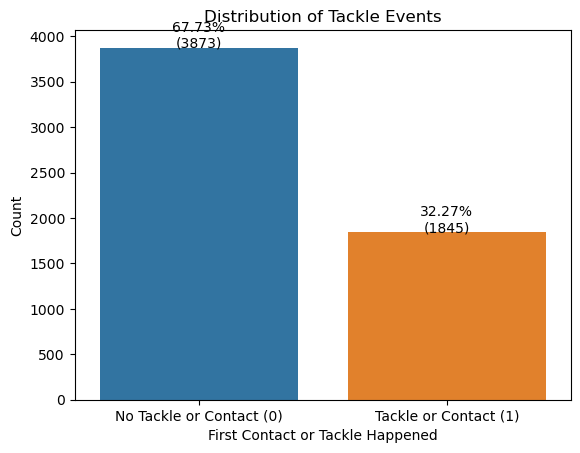

In [37]:

# Count the occurrences of each category
tackle_counts = final_df['contact_or_tackle_happened'].value_counts()
total = len(final_df['contact_or_tackle_happened'])

# Create a bar plot
sns.barplot(x=tackle_counts.index, y=tackle_counts.values)
plt.title('Distribution of Tackle Events')
plt.xlabel('First Contact or Tackle Happened')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Tackle or Contact (0)', 'Tackle or Contact (1)'])

# Add percentages and counts above bars
for index, value in enumerate(tackle_counts):
    percentage = f'{(value / total) * 100:.2f}%'
    plt.text(index, value, f'{percentage}\n({value})', ha='center')

plt.show()

In [38]:
final_df.isnull().sum()

gameId                        0
playId                        0
frameId                       0
DEF_a_sum                     0
DEF_a_avg                     0
DEF_a_std                     0
DEF_a_min                     0
DEF_a_max                     0
DEF_a_range                   0
DEF_s_sum                     0
DEF_s_avg                     0
DEF_s_std                     0
DEF_s_min                     0
DEF_s_max                     0
DEF_s_range                   0
DEF_distance_to_ball_sum      0
DEF_distance_to_ball_avg      0
DEF_distance_to_ball_std      0
DEF_distance_to_ball_min      0
DEF_distance_to_ball_max      0
DEF_distance_to_ball_range    0
contact_or_tackle_happened    0
dtype: int64

In [39]:
X = final_df[features_list]

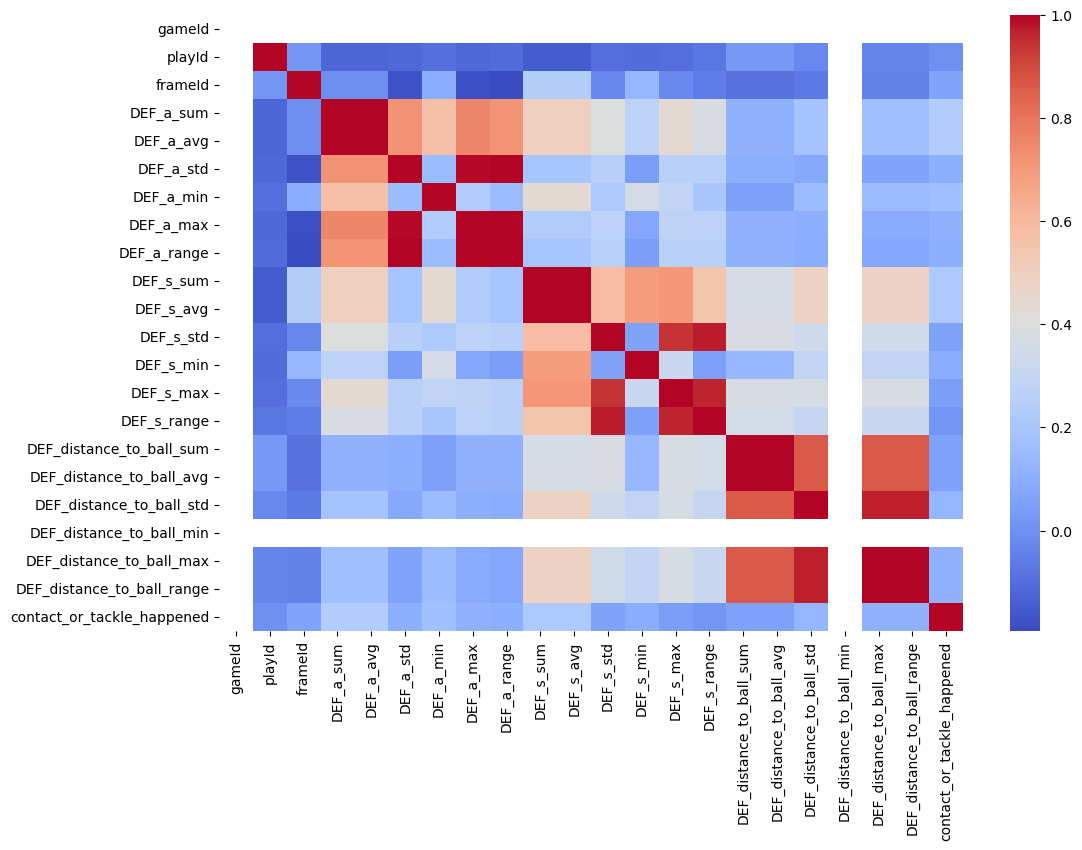

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = final_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [41]:
print('Training data set shape: ', final_df.shape)
print('Number of features: ', len(features_list))

Training data set shape:  (5718, 22)
Number of features:  18


In [42]:
final_df.columns

Index(['gameId', 'playId', 'frameId', 'DEF_a_sum', 'DEF_a_avg', 'DEF_a_std',
       'DEF_a_min', 'DEF_a_max', 'DEF_a_range', 'DEF_s_sum', 'DEF_s_avg',
       'DEF_s_std', 'DEF_s_min', 'DEF_s_max', 'DEF_s_range',
       'DEF_distance_to_ball_sum', 'DEF_distance_to_ball_avg',
       'DEF_distance_to_ball_std', 'DEF_distance_to_ball_min',
       'DEF_distance_to_ball_max', 'DEF_distance_to_ball_range',
       'contact_or_tackle_happened'],
      dtype='object')

In [43]:
# Separate identifiers
identifiers = final_df[['gameId', 'playId', 'frameId','contact_or_tackle_happened']]

In [44]:
final_df.head()

,gameId,playId,frameId,DEF_a_sum,DEF_a_avg,DEF_a_std,DEF_a_min,DEF_a_max,DEF_a_range,DEF_s_sum,...,DEF_s_min,DEF_s_max,DEF_s_range,DEF_distance_to_ball_sum,DEF_distance_to_ball_avg,DEF_distance_to_ball_std,DEF_distance_to_ball_min,DEF_distance_to_ball_max,DEF_distance_to_ball_range,contact_or_tackle_happened
0,2022091101,85,1,31.85,2.654167,1.500712,1.18,6.87,5.69,65.980000,...,2.10,20.920000,18.820000,140.322426,11.693536,7.778396,0.0,23.490125,23.490125,0
1,2022091101,85,2,37.06,3.088333,2.116231,0.93,9.43,8.50,64.949999,...,1.81,20.049999,18.239999,143.580933,11.965078,7.842833,0.0,25.180569,25.180569,0
2,2022091101,85,3,41.47,3.455833,2.637038,1.06,11.54,10.48,63.400000,...,1.42,19.000000,17.580000,149.989060,12.499088,7.845842,0.0,26.887651,26.887651,0
3,2022091101,85,4,40.30,3.358333,2.268018,0.98,10.19,9.21,62.730000,...,1.13,18.500000,17.370000,154.822917,12.901910,7.980453,0.0,28.152238,28.152238,0
4,2022091101,85,5,45.03,3.752500,3.586171,0.65,14.83,14.18,59.640000,...,0.90,15.810000,14.910000,160.515253,13.376271,8.232592,0.0,29.589055,29.589055,0


In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd



# Adding a constant to the model (for intercept)
X = add_constant(X)

# Calculating VIF for each feature
VIF_data = pd.DataFrame()
VIF_data['feature'] = X.columns
VIF_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(VIF_data)


                       feature         VIF
0                        const   17.446549
1                    DEF_a_sum         inf
2                    DEF_a_avg         inf
3                    DEF_a_std  116.290283
4                    DEF_a_min         inf
5                    DEF_a_max         inf
6                  DEF_a_range         inf
7                    DEF_s_sum         inf
8                    DEF_s_avg         inf
9                    DEF_s_std   24.636536
10                   DEF_s_min         inf
11                   DEF_s_max         inf
12                 DEF_s_range         inf
13    DEF_distance_to_ball_sum  335.234717
14    DEF_distance_to_ball_avg         inf
15    DEF_distance_to_ball_std   16.944917
16    DEF_distance_to_ball_min         NaN
17    DEF_distance_to_ball_max         inf
18  DEF_distance_to_ball_range         inf


/Users/nick/.conda/envs/advanced_ds/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/nick/.conda/envs/advanced_ds/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [46]:
final_df.columns

Index(['gameId', 'playId', 'frameId', 'DEF_a_sum', 'DEF_a_avg', 'DEF_a_std',
       'DEF_a_min', 'DEF_a_max', 'DEF_a_range', 'DEF_s_sum', 'DEF_s_avg',
       'DEF_s_std', 'DEF_s_min', 'DEF_s_max', 'DEF_s_range',
       'DEF_distance_to_ball_sum', 'DEF_distance_to_ball_avg',
       'DEF_distance_to_ball_std', 'DEF_distance_to_ball_min',
       'DEF_distance_to_ball_max', 'DEF_distance_to_ball_range',
       'contact_or_tackle_happened'],
      dtype='object')

In [47]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Set up your estimator list with only the classifier
estimators = [
    ('clf', XGBClassifier(random_state=42))  # Customize the classifier as needed
]

# Create the pipeline
pipe = Pipeline(steps=estimators)

# You can now proceed with fitting your pipeline to


In [48]:
from sklearn.model_selection import RandomizedSearchCV


# Define your search space
search_space = {
    'clf__max_depth': [2, 3, 4, 5, 6, 7, 8],
    'clf__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1.0],
    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bynode': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__reg_alpha': [0, 1, 5, 10],
    'clf__reg_lambda': [0, 1, 5, 10],
    'clf__gamma': [0, 0.1, 0.5, 1, 5, 10]
}

# Setup RandomizedSearchCV
opt = RandomizedSearchCV(pipe, param_distributions=search_space, 
                         n_iter=10, scoring='roc_auc', cv=3, 
                         random_state=42)

In [49]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Split data into features (X) and target (y)
X = final_df[features_list]
y = final_df['contact_or_tackle_happened']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model on the training data
opt.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = opt.predict(X_test)
y_pred_proba = opt.predict_proba(X_test)[:, 1]

# Print the classification report and AUC-ROC score
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba)}")


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       777
           1       0.96      0.96      0.96       367

    accuracy                           0.98      1144
   macro avg       0.97      0.97      0.97      1144
weighted avg       0.98      0.98      0.98      1144

AUC-ROC Score: 0.983524980800185


[16:03:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "clf__colsample_bylevel", "clf__colsample_bynode", "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__reg_alpha", "clf__reg_lambda", "clf__subsample" } are not used.

[0]	validation_0-logloss:0.58479	validation_1-logloss:0.58724
[1]	validation_0-logloss:0.51263	validation_1-logloss:0.51949
[2]	validation_0-logloss:0.45436	validation_1-logloss:0.46808
[3]	validation_0-logloss:0.41965	validation_1-logloss:0.43154
[4]	validation_0-logloss:0.38815	validation_1-logloss:0.40444
[5]	validation_0-logloss:0.34423	validation_1-logloss:0.36676
[6]	validation_0-logloss:0.31872	validation_1-logloss:0.34398
[7]	validation_0-logloss:0.30040	validation_1-logloss:0.32699
[8]	validation_0-logloss:0.26749	validation_1-logloss:0.30071
[9]	validation_0-logloss:0.25469	validation_1-logloss:0.28715
[10]	validation_0-log

/Users/nick/.conda/envs/advanced_ds/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-logloss:0.07509	validation_1-logloss:0.11420
[32]	validation_0-logloss:0.07114	validation_1-logloss:0.11114
[33]	validation_0-logloss:0.06899	validation_1-logloss:0.11041
[34]	validation_0-logloss:0.06603	validation_1-logloss:0.10810
[35]	validation_0-logloss:0.06372	validation_1-logloss:0.10572
[36]	validation_0-logloss:0.06070	validation_1-logloss:0.10453
[37]	validation_0-logloss:0.05785	validation_1-logloss:0.10204
[38]	validation_0-logloss:0.05612	validation_1-logloss:0.10140
[39]	validation_0-logloss:0.05525	validation_1-logloss:0.10066
[40]	validation_0-logloss:0.05416	validation_1-logloss:0.10005
[41]	validation_0-logloss:0.05205	validation_1-logloss:0.09936
[42]	validation_0-logloss:0.05069	validation_1-logloss:0.09825
[43]	validation_0-logloss:0.04930	validation_1-logloss:0.09728
[44]	validation_0-logloss:0.04706	validation_1-logloss:0.09580
[45]	validation_0-logloss:0.04410	validation_1-logloss:0.09476
[46]	validation_0-logloss:0.04206	validation_1-logloss:

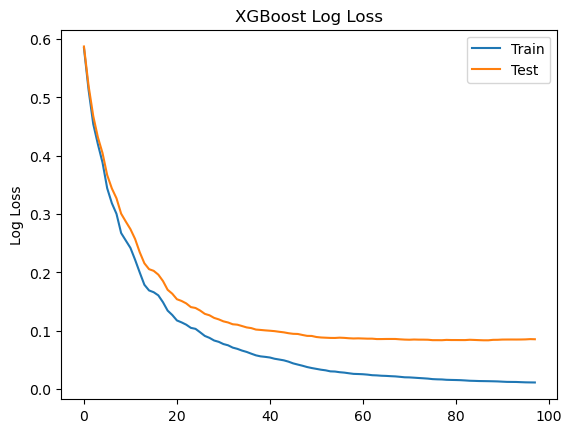

In [50]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Extract the best parameters
best_params = opt.best_params_

# Manually fit an XGBoost model with these parameters and early stopping
model = XGBClassifier(**best_params)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

# Retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()



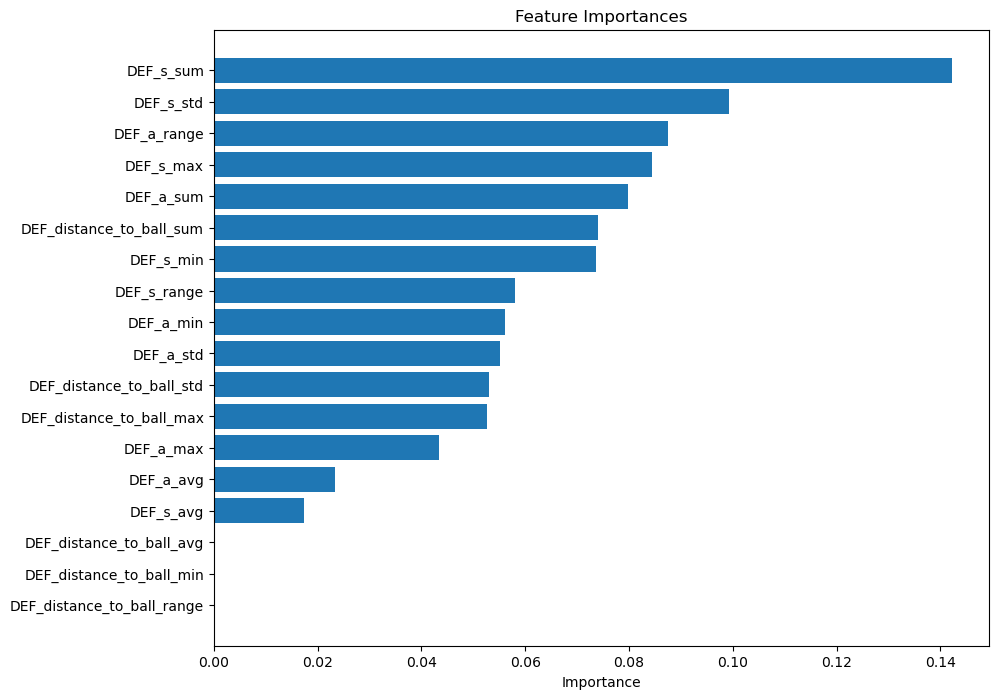

In [51]:
# Assuming 'model' is your trained XGBoost model

import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importance = model.feature_importances_

# Convert to a DataFrame
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importance})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To display the highest bar at the top
plt.show()


In [52]:
# Join predictions with identifiers
test_with_proba = identifiers.loc[X_test.index].copy()  # use loc to match the indices
test_with_proba['predicted_probability'] = y_pred_proba

# Convert probabilities to percentages
test_with_proba['predicted_probability'] = test_with_proba['predicted_probability'].apply(lambda x: round(x * 100, 2))

# Now test_with_proba contains the game, play, frame IDs, and the predicted probabilities as percentages
print(test_with_proba)
# Define the file path and name
file_path = "/Users/nick/nfl-big-data-bowl-2024/predicted_contact_or_tackle_probability_by_frame.csv"

# Save the DataFrame as a CSV file
test_with_proba.to_csv(file_path, index=False)

# Print a message to confirm the file has been saved
print(f"DataFrame saved as '{file_path}'")


          gameId  playId  frameId  contact_or_tackle_happened  \
1966  2022091101    1616       53                           0   
2857  2022091101    2386       42                           0   
4326  2022091101    3287       34                           1   
3558  2022091101    2832       18                           1   
3213  2022091101    2501       33                           0   
...          ...     ...      ...                         ...   
5270  2022091101    3789       55                           1   
527   2022091101     361       14                           0   
3903  2022091101    3080       22                           1   
3616  2022091101    2909       37                           0   
1765  2022091101    1564       58                           1   

      predicted_probability  
1966                   4.30  
2857                   1.15  
4326                  94.16  
3558                  91.99  
3213                  16.35  
...                     ...  
5270     

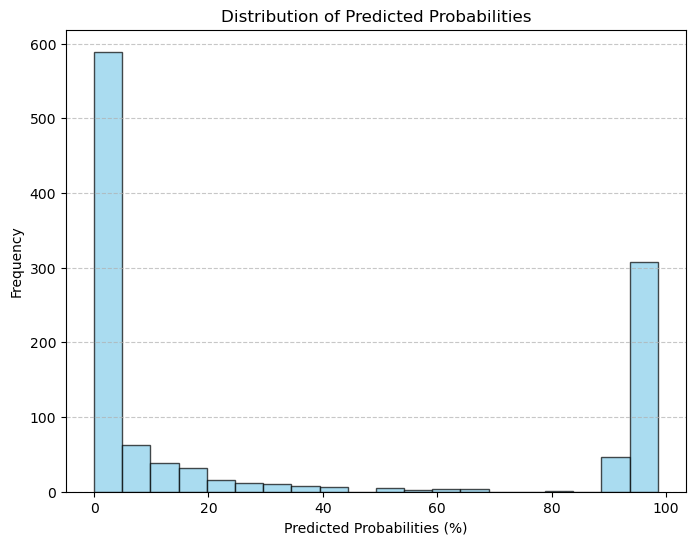

In [53]:
import matplotlib.pyplot as plt

# Extract the predicted probabilities
predicted_probabilities = test_with_proba['predicted_probability']

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(predicted_probabilities, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probabilities (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


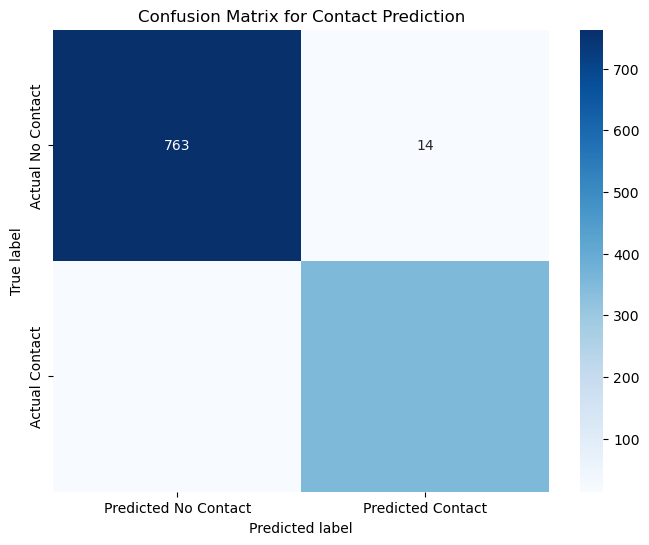

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred)

# Define the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted No Contact", "Predicted Contact"],
            yticklabels=["Actual No Contact", "Actual Contact"])

# Add labels and title for clarity
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Contact Prediction')

# Show the plot
plt.show()

In [55]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, roc_auc_score

# # Split data into features (X) and target (y)
# X = final_df[features_list]
# y = final_df['contact_or_tackle_happened']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define SMOTE and RandomUnderSampler in a pipeline
# over = SMOTE(sampling_strategy=0.1)  # Adjust the sampling_strategy as needed
# under = RandomUnderSampler(sampling_strategy=0.5)
# pipeline = Pipeline([('o', over), ('u', under)])

# # Apply the pipeline to resample X_train and y_train
# X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# # Initialize XGBoost with class weight (adjust as needed or remove)
# scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
# xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight)

# # Train the model on the resampled training data
# xgb_model.fit(X_train_resampled, y_train_resampled)

# # Predict and evaluate on the original test set
# y_pred = xgb_model.predict(X_test)
# y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
# print(classification_report(y_test, y_pred))
# print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba)}")

In [56]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
# Extract features and target
X = final_df[features_list]  # Replace features_list with your actual list of features
y = final_df['contact_or_tackle_happened']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter if convergence issues arise
log_reg.fit(X_train, y_train)
# Get predicted probabilities for the positive class
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Sort the probabilities in descending order
sorted_proba = np.sort(y_pred_proba)[::-1]

# Find a threshold: this is a simple approach, you may want to refine this
num_samples = int(len(y_test) * 0.0184)  # Let's say we want the top 5% scores to be class '1'
threshold = sorted_proba[num_samples - 1]

# Apply the threshold to get the final predictions
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
# Print classification report for the adjusted threshold
print(classification_report(y_test, y_pred_adjusted))

# AUC-ROC Score
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba)}")


              precision    recall  f1-score   support

           0       0.69      1.00      0.82       777
           1       0.86      0.05      0.10       367

    accuracy                           0.69      1144
   macro avg       0.78      0.52      0.46      1144
weighted avg       0.75      0.69      0.58      1144

AUC-ROC Score: 0.7232105597228213


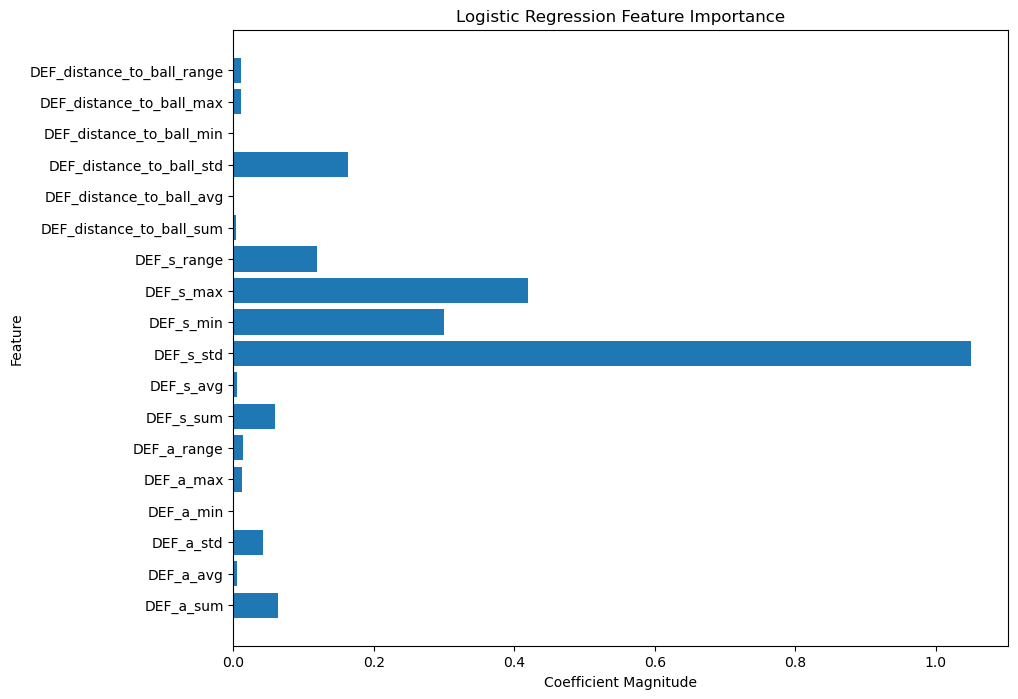

In [57]:
import numpy as np

# Assuming your logistic regression model is named log_reg and is already trained
log_reg_coef = np.abs(log_reg.coef_[0])  # Taking absolute value for magnitude

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(range(len(features_list)), log_reg_coef, align='center')
plt.yticks(range(len(features_list)), features_list)
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance')
plt.show()
